### Since the autoencoder did not result in good results, the cells corresponding to classification were changed to markdown so they did not run

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import numpy as np
import numpy.matlib
import math
import random
import timit_utils as tu
import timit_utils.audio_utils as au
import timit_utils.drawing_utils as du

corpus = tu.Corpus('TIMIT')
train = corpus.train
test = corpus.test
corpus.train, corpus.test

(<timit_utils.core.SubCorpus at 0x1f7a2f32fc8>,
 <timit_utils.core.SubCorpus at 0x1f7a4d2df08>)

### Check for length of sentences.

In [2]:
sentence_lengths = []
for p in range(len(train.people)):
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in training set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in training set is ', min(sentence_lengths)/16000, ' seconds.')
#plt.hist([x / 16000 for x in sentence_lengths], bins=100)
#plt.title('Histogram of Training Sentence Lengths')
#plt.xlabel('Length [sec]')
#plt.ylabel('Number of Sentences')
#plt.show()

Max sentence length in training set is  7.7888125  seconds.
Min sentence length in training set is  0.91525  seconds.


In [3]:
sentence_lengths = []
for p in range(len(test.people)):
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        sentence_lengths.append(len(sentence))
print('Max sentence length in testing set is ', max(sentence_lengths)/16000, ' seconds.')
print('Min sentence length in testing set is ', min(sentence_lengths)/16000, ' seconds.')
#plt.hist([x / 16000 for x in sentence_lengths], bins=100)
#plt.title('Histogram of Testing Sentence Lengths')
#plt.xlabel('Length [sec]')
#plt.ylabel('Number of Sentences')
#plt.show()

Max sentence length in testing set is  7.57125  seconds.
Min sentence length in testing set is  1.0944375  seconds.


### Make all training and testing samples the same length in time.

In [4]:
data_set = []
label_id = []
for p in range(len(train.people)):
    count = 0
    for s in range(len(train.person_by_index(p).sentences)):
        sentence = train.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(train.person_by_index(p).name)
for p in range(len(test.people)):
    count = 0
    for s in range(len(test.person_by_index(p).sentences)):
        sentence = test.person_by_index(p).sentence_by_index(s).raw_audio
        data_set.append(sentence)
        label_id.append(test.person_by_index(p).name)
num_speakers = len(set(label_id))
print('Number of speakers in data: ', num_speakers)

Number of speakers in data:  630


### How many speakers are in test and train sets?

In [5]:
num_speakers = 15 # number of speakers being considered
le1 = preprocessing.LabelEncoder()
le1.fit(label_id)
label_id = le1.transform(label_id)

sub_data_set = []
sub_label_id = []
speak_ind = []
for ind1 in range(num_speakers):
    ind2 = np.random.randint(630, size=1)
    while ind2[0] in speak_ind is False:
        ind2 = np.random.randint(630, size=1)
    speak_ind.append(ind2[0])
act_ind = []
for ID in speak_ind:
    act_ind= np.where(label_id == ID)
    sub_data_set = sub_data_set+data_set[act_ind[0][0]:act_ind[0][-1]+1]
    sub_label_id = sub_label_id+label_id[act_ind[0]].tolist()

### Next cell makes sure all speakers are in both the training and test set, but no speech segments are included in both sets.

In [6]:
L = 1 # length of samples in seconds
Fs = 16000

num_train_per_test = 3 # for every 3 training sentences, there is 1 testing sentence
training_set = []
training_label_id = []
testing_set = []
testing_label_id = []
for ID in set(sub_label_id):
    person_ind = [i for i, x in enumerate(sub_label_id) if x == ID]
    for i, sent_per_ID in enumerate(person_ind):
        if i%(num_train_per_test+1) == 0:
            testing_set.append(sub_data_set[sent_per_ID])
            testing_label_id.append(sub_label_id[sent_per_ID])
        else:
            training_set.append(sub_data_set[sent_per_ID])
            training_label_id.append(sub_label_id[sent_per_ID])

ave_seconds_per_ID = sum(sentence_lengths)/(Fs*len(sentence_lengths))*10
num_samps_per_ID = round(ave_seconds_per_ID)*10
num_samps_per_ID_test = round(num_samps_per_ID*(1/(num_train_per_test+1)))
num_samps_per_ID_train = num_samps_per_ID-num_samps_per_ID_test
train_set = []
train_l = []
test_set = []
test_l = []
for ID_i, ID in enumerate(set(sub_label_id)):
    train_person_ind = [i for i, x in enumerate(training_label_id) if x == ID]
    test_person_ind = [i for i, x in enumerate(testing_label_id) if x == ID]
    for samp in range(num_samps_per_ID_train):
        sent = random.choice(train_person_ind)
        while len(training_set[sent]) < round(Fs*L):
            sent = random.choice(train_person_ind)
        start_i = random.randint(0,len(training_set[sent])-round(Fs*L))
        train_set.append(training_set[sent][start_i:start_i+round(Fs*L)])
        train_l.append(ID_i)
    for samp in range(num_samps_per_ID_test):
        sent = random.choice(test_person_ind)
        while len(testing_set[sent]) < round(Fs*L):
            sent = random.choice(test_person_ind)
        start_i = random.randint(0,len(testing_set[sent])-round(Fs*L))
        test_set.append(testing_set[sent][start_i:start_i+round(Fs*L)])
        test_l.append(ID_i)

In [7]:
train_max=np.array([np.max(train_set,1)]).T
train_max=np.matlib.repmat(train_max,1,np.shape(train_set)[1])
train_set=np.divide(train_set,train_max)
train_set=train_set[0:1000]

test_max=np.array([np.max(test_set,1)]).T
test_max=np.matlib.repmat(test_max,1,np.shape(test_set)[1])
test_set=np.divide(test_set,test_max)
test_set=test_set[0:500]

In [8]:
print(np.shape(test_set))

(500, 16000)


### Data loaders for time-series input.

In [9]:
batch_size = 100
train_loader,test_loader = {},{}
num_speakers = len(set(train_l))
train_list = []
for ind, data in enumerate(train_set):
    train_list.append((data, train_l[ind]))
test_list = []
for ind, data in enumerate(test_set):
    test_list.append((data, test_l[ind]))
train_loader['timit'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['timit'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=False, num_workers=0)



In [10]:
class CAE(nn.Module):
    def __init__(self,n_in,n_hid,n_hid2, n_hid3, z_dim):
        super(CAE, self).__init__()
        self.enc_lin1 = nn.Linear(n_in, n_hid)
        self.enc_lin2 = nn.Linear(n_hid, n_hid2)
        self.enc_lin3 = nn.Linear(n_hid, n_hid3)
        self.enc_lin4 = nn.Linear(n_hid3, z_dim)

        self.dec_lin1 = nn.Linear(z_dim, n_hid3)
        self.dec_lin2 = nn.Linear(n_hid3, n_hid)
        self.dec_lin3 = nn.Linear(n_hid2, n_hid)
        self.dec_lin4 = nn.Linear(n_hid, n_in)
    
    def encode(self,x):
        x = F.relu(self.enc_lin1(x))
        x = F.relu(self.enc_lin3(x))
        #x = F.relu(self.enc_lin3(x))
        x = self.enc_lin4(x)
        return x
    
    def decode(self,x):
        x = F.relu(self.dec_lin1(x))
        x = F.relu(self.dec_lin2(x))
        #x = F.relu(self.dec_lin3(x))
        x = torch.tanh(self.dec_lin4(x))
        return x
    
    def forward(self, x):
        enc = self.encode(x)
        dec = self.decode(enc)
        return enc, dec

criterion  = nn.MSELoss()
lam= 1e-3
def contractive_loss(W, x, recons_x, h,lam):
    mse = criterion(recons_x, x)
    dh = h*(1-h)
    w_sum = torch.sum(W**2, dim=1)
    w_sum = w_sum.unsqueeze(1)
    contractive_loss_value = torch.sum(torch.mm(dh**2, w_sum),0)
    return mse + contractive_loss_value.mul(lam)

In [11]:
def train(model, device, train_loader, optimizer, epoch):
    train_loss = 0
    model.train()
    model.double()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        h, output = model(data)
        W = model.state_dict()['enc_lin4.weight']
        
        loss = contractive_loss(W, data, output, h, lam) #sometimes different criteria requires multiplying by batch size
        loss.backward()
        train_loss += loss.item()
        train_loss=train_loss/(batch_idx+1)

        optimizer.step()
        #if batch_idx % (len(train_loader)//2) == 0:
            #print('Train({})[{:.0f}%]: Loss: {:.4f},Train Accuracy: {:.4f}%'.format(
                #epoch, 100. * batch_idx / len(train_loader), train_loss,train_acc))
    return train_loss
            
def test(model, device, test_loader, epoch):
    model.eval()
    model.double()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            h, output = model(data)
            W = model.state_dict()['enc_lin4.weight']
            loss= contractive_loss(W, data, output, h, lam) # sum up batch loss
            test_loss+=loss.item()

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    #print('Test({}): Loss: {:.4f},Test Accuracy: {:.4f}%'.format(
        #epoch, test_loss, test_acc))
    return test_loss

In [12]:
def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

## Autoencoder Training

Epoch= 1
Train Loss= 0.0021664492087749535
Test Loss= 0.019214971325174312
Epoch= 5
Train Loss= 0.001994718720099735
Test Loss= 0.018196386609718843


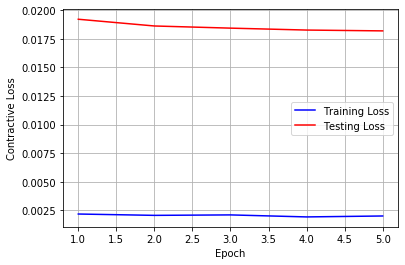

Epoch= 10
Train Loss= 0.0019752355361090683
Test Loss= 0.017933049609386253


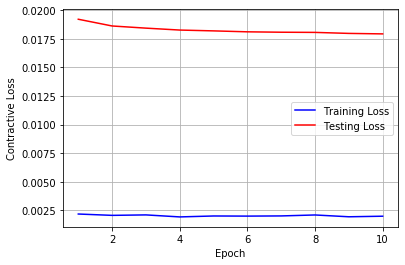

Epoch= 15
Train Loss= 0.001938699764554423
Test Loss= 0.01785162320425703


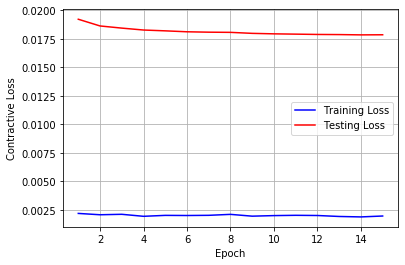

Epoch= 20
Train Loss= 0.0019087277343177056
Test Loss= 0.017767941788977892


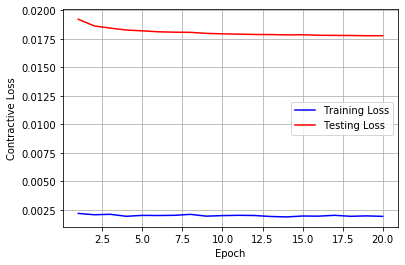

In [13]:
device = 'cpu'
data_name = 'timit'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'

num_epochs = 20
lr = 0.0001
device = torch.device(device)

n_in = np.shape(train_set)[1]
n_hid = 8000
n_hid2 = 6000
n_hid3 = 4000
z_dim = 2000
model = CAE(n_in, n_hid, n_hid2, n_hid3, z_dim).to(device)
optimizer=optim.Adam(model.parameters(), lr=lr, betas=(0.98, 0.999), eps=1e-08, weight_decay=0.00001, amsgrad=False)
scheduler = make_scheduler(scheduler_name, optimizer, milestones=[5], factor=0.01)

train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]
for epoch in range(1, num_epochs + 1):
    train_loss_tmp=train(model, device, train_loader[data_name], optimizer, epoch)
    test_loss_tmp=test(model, device, test_loader[data_name], epoch)
    
    train_loss.append(train_loss_tmp)
    test_loss.append(test_loss_tmp)
    
    #scheduler.step()
    
    if epoch%5==0 or epoch==1:  
        print('Epoch=',epoch)
        print('Train Loss=',train_loss_tmp)
        print('Test Loss=',test_loss_tmp)
        #print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))
        
    if epoch%5==0:
        plt.figure(1)
        plt.plot(np.arange(1,epoch+1),train_loss,color='blue',label='Training Loss')
        plt.plot(np.arange(1,epoch+1),test_loss,color='red',label='Testing Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Contractive Loss')
        plt.grid()
        plt.show()



## Save model in different ways

PATH_dict='./ckpt_state_dics.pth'
torch.save(model.state_dict(),PATH_dict)


PATH_all='./ckpt_entire.pth'
torch.save(model,PATH_all)

PATH_dict='./ckpt_state_dics.pth'
device='cuda'
device = torch.device(device)
n_in = np.shape(train_set)[1]
n_hid = 2000
n_hid2 = 1000
z_dim = 400
model=VAE(n_in,n_hid,n_hid2,z_dim).to(device)
model.load_state_dict(torch.load(PATH_dict))


In [14]:
model.eval()
model.double()
device='cpu'
device = torch.device(device)
x_train1=torch.from_numpy(train_set[0:100,:]).to(device)
x_test1=torch.from_numpy(test_set[0:100,:]).to(device)

train_embed=model.encode(x_train1)
test_embed=model.encode(x_test1)
_,output_test=model(x_test1[0,:])

In [15]:
output_test=output_test.detach().cpu().numpy()
train_embed=train_embed.detach().cpu().numpy()
test_embed=test_embed.detach().cpu().numpy()

Text(0.5, 1.0, 'Original')

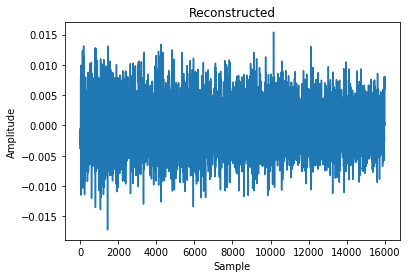

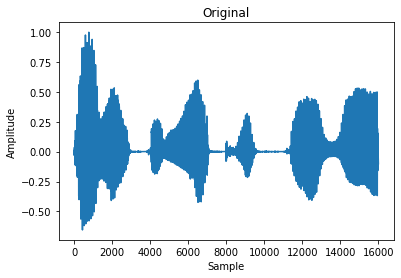

In [16]:
samp=x_test1[0,:].detach().cpu().numpy()
plt.figure()
plt.plot(output_test)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Reconstructed')
plt.figure()
plt.plot(samp)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Original')

In [17]:
batch_size=100
train_loader,test_loader = {},{}
train_list = []
for ind, data in enumerate(train_embed):
    train_list.append((data, train_l[ind]))
test_list = []
for ind, data in enumerate(test_embed):
    test_list.append((data, test_l[ind]))
train_loader['AE'] = torch.utils.data.DataLoader(train_list, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader['AE'] = torch.utils.data.DataLoader(test_list, batch_size=batch_size, shuffle=False, num_workers=0)

class timit_AE_nn(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(timit_AE_nn, self).__init__()
        self.fc1 = nn.Linear(in_channels, 400,bias=True)
        self.fc2 = nn.Linear(400,200,bias=True)
        self.fc3 = nn.Linear(200,100,bias=True)
        self.fc4 = nn.Linear(100,out_channels,bias=True)

    def forward(self, x):
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=F.relu(self.fc3(x))
        x=F.softmax(self.fc4(x),dim=1)
        return x

def train(model, device, train_loader, criterion, optimizer, epoch):
    train_loss = 0
    correct_train=0
    model.train()
    model.double()
    for batch_idx, (data, target) in enumerate(train_loader):
        #if batch_idx==0:
            #plt.figure()
            #plt.plot(data[0,:])
        data, target = data.to(device), target.to(device)
        #data = data.reshape(len(data),1,data[0].size()[0])
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target) #sometimes different criteria requires multiplying by batch size
        loss.backward()

        pred_train = output.argmax(dim=1, keepdim=True)
        correct_train += pred_train.eq(target.view_as(pred_train)).sum().item()
        train_loss += loss.item()
        train_loss=train_loss/(batch_idx+1)
        train_acc=100. * correct_train / len(train_loader.dataset)
        optimizer.step()
        #if batch_idx % (len(train_loader)//2) == 0:
            #print('Train({})[{:.0f}%]: Loss: {:.4f},Train Accuracy: {:.4f}%'.format(
                #epoch, 100. * batch_idx / len(train_loader), train_loss,train_acc))
    return train_loss,train_acc
            
def test(model, device, test_loader, criterion, epoch):
    model.eval()
    model.double()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            #data = data.reshape(len(data),1,data[0].size()[0])
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            
            #print(output)
            #print(target)
            #print(pred)
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_acc=100. * correct / len(test_loader.dataset)

    test_loss = (test_loss*batch_size)/len(test_loader.dataset)
    #print('Test({}): Loss: {:.4f},Test Accuracy: {:.4f}%'.format(
        #epoch, test_loss, test_acc))
    return test_loss,test_acc

def make_optimizer(optimizer_name, model, **kwargs):
    if optimizer_name=='Adam':
        optimizer = optim.Adam(model.parameters(),lr=kwargs['lr'])
    elif optimizer_name=='SGD':
        optimizer = optim.SGD(model.parameters(),lr=kwargs['lr'],momentum=kwargs['momentum'], weight_decay=kwargs['weight_decay'])
    else:
        raise ValueError('Not valid optimizer name')
    return optimizer
    
def make_scheduler(scheduler_name, optimizer, **kwargs):
    if scheduler_name=='MultiStepLR':
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=kwargs['milestones'],gamma=kwargs['factor'])
    else:
        raise ValueError('Not valid scheduler name')
    return scheduler

device = 'cuda'
data_name = 'AE'
optimizer_name = 'SGD'
scheduler_name = 'MultiStepLR'
num_epochs = 5000
lr = 0.1
device = torch.device(device)
in_channels = np.shape(train_embed)[1]
out_channels = num_speakers
model = timit_AE_nn(in_channels,out_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

scheduler = make_scheduler(scheduler_name, optimizer, milestones=[10,20,30], factor=0.1)

train_loss=[]
test_loss=[]
train_acc=[]
test_acc=[]
for epoch in range(1, num_epochs + 1):
    train_loss_tmp, train_acc_tmp=train(model, device, train_loader[data_name], criterion, optimizer, epoch)
    test_loss_tmp, test_acc_tmp=test(model, device, test_loader[data_name], criterion, epoch)
    
    train_loss.append(train_loss_tmp)
    test_loss.append(test_loss_tmp)
    
    train_acc.append(train_acc_tmp)
    test_acc.append(test_acc_tmp)
    #scheduler.step()
    
    if epoch%20==0:
        plt.figure(1)
        plt.plot(np.arange(1,epoch+1),train_loss,color='blue',label='Training Loss')
        plt.plot(np.arange(1,epoch+1),test_loss,color='red',label='Testing Loss')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.grid()
        plt.show()

        plt.figure(2)
        plt.plot(np.arange(1,epoch+1),train_acc,color='blue',label='Training Accuracy')
        plt.plot(np.arange(1,epoch+1),test_acc,color='red',label='Testing Accuracy')
        plt.legend()
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid()
        plt.show()
        
        print('Epoch=',epoch)
        print('Train Acc=',train_acc_tmp)
        print('Test Acc=',test_acc_tmp)
        #print('Optimizer Learning rate: {0:.4f}'.format(optimizer.param_groups[0]['lr']))

